<a href="https://colab.research.google.com/github/takemuralab/OAcenter_ai_project/blob/main/Lesson8_TimeSeriesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 季節などの周期生で売り上げを予測　（時系列分析）

　**過去の目的変数の値をもとに、未来の目的変数の数値を予想する**

 時系列分析の根本にある考えは、 **周期性を前提とした予測**を行うこと

 　回帰　→　数値を予測する

 　前回の予測モデル : 直近の「利用数」
 　
 　入力データ　：　曜日・天気・気温など

 　単純な時系列分析 :　利用数以外の項目は利用しない、過去の利用数のデータと時系列のみ利用

 　本当に目的の数値データの過去分だけで未来を予測できるものなのか？

 　「日付」が重要な意味を持つ　
 
 　「日付」をデータとして解析すると「年」「月」「曜日」の情報を抽出できる

 　**周期性があることを前提とした予測**を具体的には目的変数の数値データを「日単位」「週単位」「年単位」の周期関数と, 「トレンド」と呼ばれる長期間の変化の和と考える.

  過去の履歴データに対してもっともよく適合した**「周期関数」**と「トレンド」を見つけることで将来を予想する

  **時系列分析の特徴**

  「信頼区間」　・・・　時系列分析では、単に予想結果を算出するだけでなく、「ここからここまでの範囲に予測結果がxx [%]の結果で入る」といった信頼区間がわかり、リスクをコントロールできる

## 例題のデータとユースケース

 例題データ　: Bike Sharing Dataset Data Set (前回のものと同じ）

 演習１　：　　日付と予測対象項目の２項目でのモデル

 演習２：　チューニングの手段として、他の項目もモデルに取り入れる方法を試す


### モデルの概要
　
　　２０１７年にFacebook社が**Prophet**と呼ばれる時系列分析ようのライブラリを公開


#### データ項目メモ

instant インデックス  
dteday 日付(yy-mm-dd)  
season 季節 (1: 冬 2: 春 3: 夏 4:秋)  
yr 年 (0: 2011, 1:2012)  
mnth 月  (1 - 12)  
hr 時間  (0 - 23)  
holiday 祝日  
weekday 曜日 (0 - 6)  
workingday  勤務日 (1: 勤務日 0: 休日)  
weathersit 天気 (1: 晴れから曇り 2: 霧 3: 小雨 4: 大雨)  
temp 気温 (正規化済み)  
atemp 体感気温 (正規化済み)  
hum 湿度 (正規化済み)  
windspeed 風速 (正規化済み)  
casual 臨時ユーザー利用数  
registered 登録ユーザー利用数  
cnt 全体ユーザー利用数  

In [29]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1

In [30]:
# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format

# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14

# 乱数の種
random_seed = 123

In [31]:
# ダウンロード元URL
url = 'https://archive.ics.uci.edu/ml/\
machine-learning-databases/00275/\
Bike-Sharing-Dataset.zip'

# 公開データのダウンロードと解凍
!wget $url -O Bike-Sharing-Dataset.zip | tail -n 1
!unzip -o Bike-Sharing-Dataset.zip | tail -n 1

--2021-01-06 02:18:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K  1.03MB/s    in 0.3s    

2021-01-06 02:18:20 (1.03 MB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]

  inflating: hour.csv                


In [32]:
# day.csvをデータフレームに取り込み
# 日付を表す列はparse_datesで指定する
df = pd.read_csv('day.csv', parse_dates=[1])

In [33]:
# instant は連番で予測で不要なので削除
df = df.drop('instant', axis=1)

# 項目名の日本語化

columns = [
    '日付',  '季節',  '年', '月', '祝日', '曜日', '勤務日', '天気', 
    '気温', '体感温度',  '湿度', '風速',
    '臨時ユーザ利用数', '登録ユーザ利用数', '全体ユーザ利用数'
]

# 項目名を日本語に置き換え
df.columns = columns

In [34]:
#先頭５行の確認
display(df.head())

#最終５行の確認
display(df.tail())

,日付,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,臨時ユーザ利用数,登録ユーザ利用数,全体ユーザ利用数
0,2011-01-01,1,0,1,0,6,0,2,0.3442,0.3636,0.8058,0.1604,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.3635,0.3537,0.6961,0.2485,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.1964,0.1894,0.4373,0.2483,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.2000,0.2121,0.5904,0.1603,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.2270,0.2293,0.4370,0.1869,82,1518,1600


,日付,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,臨時ユーザ利用数,登録ユーザ利用数,全体ユーザ利用数
726,2012-12-27,1,1,12,0,4,1,2,0.2542,0.2266,0.6529,0.3501,247,1867,2114
727,2012-12-28,1,1,12,0,5,1,2,0.2533,0.2550,0.5900,0.1555,644,2451,3095
728,2012-12-29,1,1,12,0,6,0,2,0.2533,0.2424,0.7529,0.1244,159,1182,1341
729,2012-12-30,1,1,12,0,0,0,1,0.2558,0.2317,0.4833,0.3508,364,1432,1796
730,2012-12-31,1,1,12,0,1,1,2,0.2158,0.2235,0.5775,0.1548,439,2290,2729


### データ前処理
　
　 Prophetは、専門知識がなくすぐに時系列分析できる便利なライブラリ

　　守らないといけない作法　：　学習データに関する形式　

　　入力変数　：データフレームである必要がある

 項目名に関しても次の命令規則を守る必要がある
 * **日付 : ds**
 * **目的変数 : y**

In [35]:
# 「日付」と「登録ユーザ利用数」のみ抽出し、
# 列名を日付 : ds,  登録ユーザ利用数 : y に置き換えたデータフレーム　df2を作る

# データフレーム全体のコピー
df2 = df.copy()

# 「日付」「登録ユーザ利用数」列の抽出
df2 = df2[['日付', '登録ユーザ利用数']]

# 列名の置き換え
df2.columns = ['ds', 'y']

# 結果確認
display(df2.head())

,ds,y
0,2011-01-01,654
1,2011-01-02,670
2,2011-01-03,1229
3,2011-01-04,1454
4,2011-01-05,1518


In [36]:
# 分割日 mdayの設定
mday = pd.to_datetime('2012-11-1')

# 訓練用　indexと検証用 indexを作る
train_index = df2['ds'] < mday
test_index = df2['ds'] >= mday

#　入力データの分割
x_train = df2[train_index]
x_test = df2[test_index]

#　日付データの分割（グラフ表示用)
dates_test = df2['ds'][test_index]

### アルゴリズムの選択

* Prophetを利用

In [37]:
# ライブラリのインポート
from fbprophet import Prophet

# モデルの選択
# 三つのseasonality パラメータの設定が重要
# 今回のデータの場合、　日単位のデータなのでdaily_seasonalityは不要
# weekly_seasonality と daily_seasonalityは
# True / Falseの他に数値で指定することも可能　（三角関数の個数）
# seasonality_mode : additive(デフォルト) multiplicative

m1 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False,
             seasonality_mode='multiplicative')

必要パラメータ

 * yearly_seasonality
 * weekly_seasonality
 * daily_seasonality

 「年周期」「週周期」「日周期」がそれぞれ周期性を持つかどうかを指定できる

 今回のデータ　：　２年分の日毎の自転車利用数

 データは少ないが...
  * 年周期パターン　（夏に多く利用されて冬は少ないなど）　ありそう
  *　　週周期パターン　(平日が多くて土日が少ないなど）　　ありそう
  * 日周期　（時間でのデータがないのでわからない）

  True / False以外でも指定可能 （値が大きいほど細かい近似が可能だが過学習になる可能性がある）

　　　seasonality_mode :  addaptive (加算的）とmultiplicative (乗算的）を選択可能
　
　　　　default : additive  ベースラインとしての「トレンド」に対して、予測した周期関数が足し算の形で影響する

　　　　multiplicativeの場合、例えば土日は、平日よりも自転車の利用数が減ると想定すると

   1000人と２０００人の場合を考えると, -200人のような形でなく20%減るのように割合で聞いていることが想定される。そのような場合は**multiplicative**を利用する



In [38]:
# 学習
m1.fit(x_train)

In [39]:
# 予測用データの作成
# （日付 dsだけの入ったデータフレーム)
# 61は予想したい日数（2012-11-1から2012-12-31)
future1 = m1.make_future_dataframe(periods=61, freq='D')

# 結果確認
display(future1.head())
display(future1.tail())

,ds
0,2011-01-01
1,2011-01-02
2,2011-01-03
3,2011-01-04
4,2011-01-05


,ds
726,2012-12-27
727,2012-12-28
728,2012-12-29
729,2012-12-30
730,2012-12-31


予測用のデータは、　学習済みのProphetのモデルが持つ関数make_future_dataframeを利用

「学習済みのProphetのモデル」という点がポイント

この関数は、単に未来の日付を作るだけでなく、学習時に利用したデータの日付も精製していて、その後に未来の日付を足した形で出力する

 make_future_dataframe関数の引数　

 * periods ....  何階分s機のデータ　（61日先）まで作るかを指定
 * freq .... どのような感覚dえ日付を作るか(D=1日単位）

In [40]:
# 予測
# 結果はデータフレームで戻ってくる
fcst1 = m1.predict(future1)

###  評価

#### 要素ごとのグラフ表示
　plot_components関数を呼び出すことによるグラフ表示の方法

 Prophet独自の評価方法である

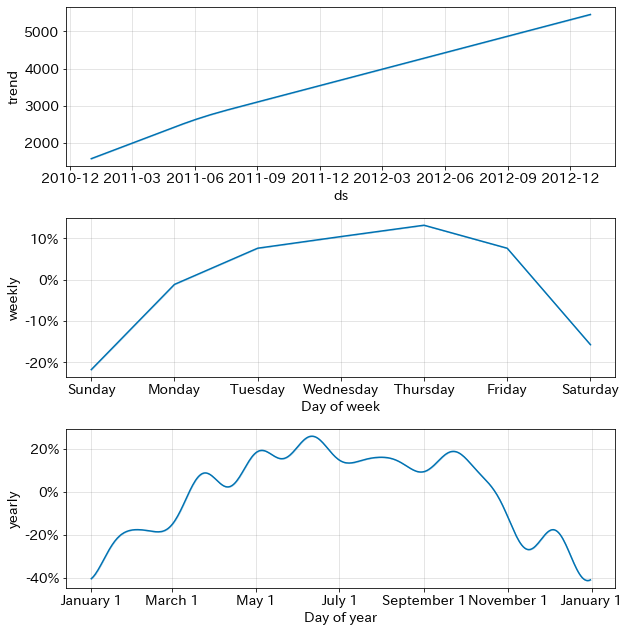

In [48]:
# 要素毎のグラフ描画
# この段階では、トレンド、　週周期、　年周期
fig = m1.plot_components(fcst1)
plt.show()

* 訓練データ・検証データ全体のグラフ化
　

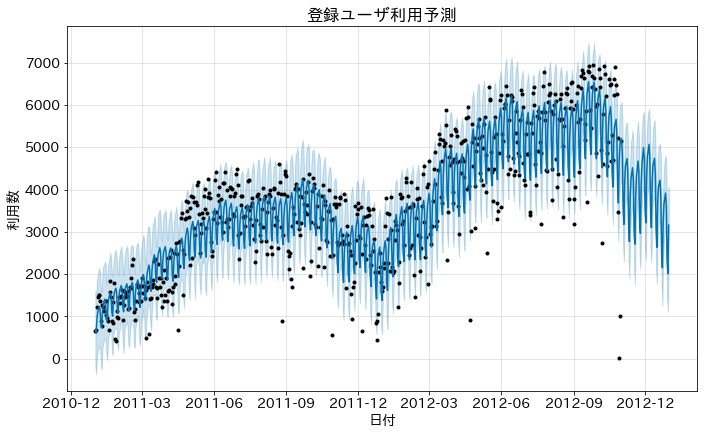

In [42]:
# 訓練データ・検証データ全体のグラフ化
fig, ax = plt.subplots(figsize=(10,6))

# 予測結果のグラフ表示 ( prophetの関数)
m1.plot(fcst1, ax=ax)

# タイトルの表示など
ax.set_title('登録ユーザ利用予測')
ax.set_xlabel('日付')
ax.set_ylabel('利用数')

# グラフの表示
plt.show()

グラフ表示機能 : Prophetの独自機能　

学習済みモデル (ml）に対してplot関数を呼び出すと用事される

* 中央の青色の線 ...  もっとも確率の高い値
* 水色の線　....  確率80%でこの領域に含まれる　（信頼区間）
* 黒の点 .... 正解データ


#### $R^{2}$値の計算

In [43]:
# ypred1 : fcstlから予測部分のみ抽出する
ypred1 = fcst1[-61:][['yhat']].values

# ytest1 : 予測期間中の正解データ
ytest1 = x_test['y'].values

#R2値の計算
from sklearn.metrics import r2_score
score = r2_score(ytest1, ypred1)

#結果確認
print(f'R2 score: {score:.4f}')

R2 score: 0.3725


チューニングの余地があることが明らかである

###  検証期間中のグラフ表示


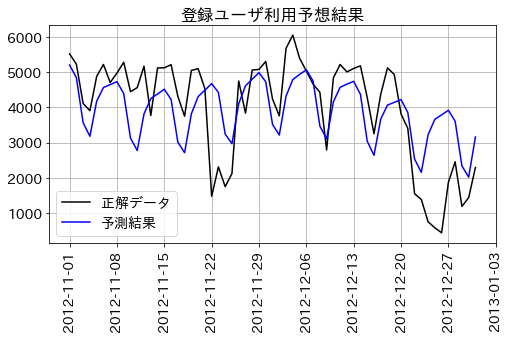

In [44]:
# 時系列グラフの描画
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8,4))

# グラフの描画
ax.plot(dates_test, ytest1, label='正解データ', c='k')
ax.plot(dates_test, ypred1, label='予測結果', c='b')

# 日付目盛間隔
# 木曜日毎に日付を表示
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

#　方眼表示など
ax.grid()
ax.legend()
ax.set_title('登録ユーザ利用予想結果')

# 画面出力
plt.show()

###  チューニング1

 「祝日」モデルの組み込み ....  holidaysパラメータを利用

 休日だけでなく「プロ野球試合日」や「コンサートの開催日」のような不規則イベントも汎用的に利用可能

In [51]:
# 休日の抽出
df_holiday = df[df['祝日']==1]
holidays = df_holiday['日付'].values

# データフレーム形式に変換
df_add = pd.DataFrame({'holiday':'holi',
                       'ds':holidays, 
                       'lower_window':0,
                       'upper_window':0
})

# 結果確認
display(df_add.head())
display(df_add.tail())


,holiday,ds,lower_window,upper_window
0,holi,2011-01-17,0,0
1,holi,2011-02-21,0,0
2,holi,2011-04-15,0,0
3,holi,2011-05-30,0,0
4,holi,2011-07-04,0,0


,holiday,ds,lower_window,upper_window
16,holi,2012-09-03,0,0
17,holi,2012-10-08,0,0
18,holi,2012-11-12,0,0
19,holi,2012-11-22,0,0
20,holi,2012-12-25,0,0


dfの中で, 「祝日」 = 1になっている行だけを抽出し, その日付列をholidaysに代入

次に、変数holidaysを利用してデータフレームdf_addを作成

lower_windowとupper_window　：　イベント発生日の前後何日に影響するかを指定する変数

休日の場合、　影響は0日なのでいずれも０を代入している

項目 holidayはイベントの種類を示している.

今回のイベントは「休日」の１種類だけだが、　「コンサート」などの影響があれば追加する



In [47]:
# 休日 (df_add)をモデルに入力する

# アルゴリズム選択
# holidaysパラメータを追加してモデルm2を生成
m2 = Prophet(yearly_seasonality=True, 
             weekly_seasonality=True, daily_seasonality=False,
             holidays = df_add, seasonality_mode='multiplicative')

# 学習
m2 = m2.fit(x_train)

# 予測
fcst2 = m2.predict(future1)

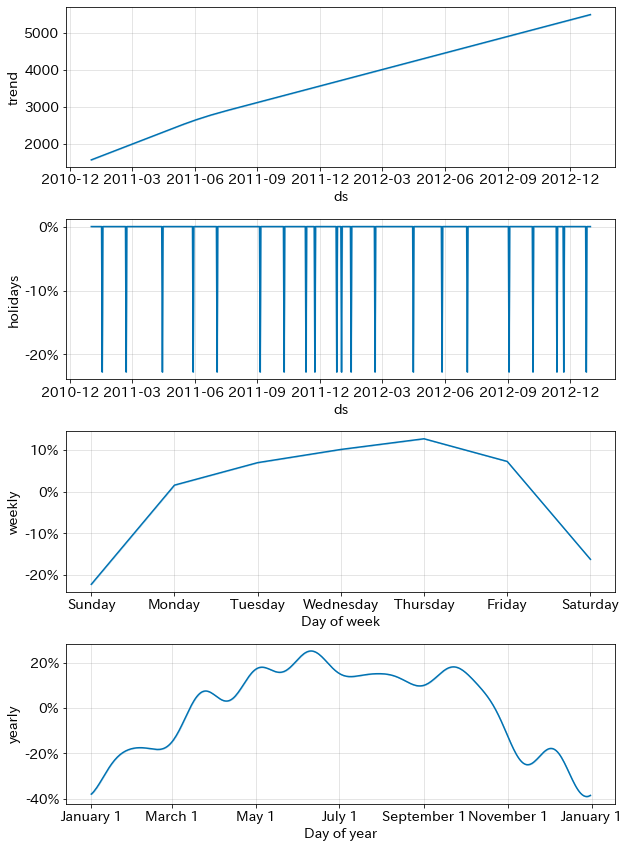

In [49]:
# 要素毎のグラフ描画
# この段階では、トレンド、　週周期、　年周期
fig = m2.plot_components(fcst2)
plt.show()

In [52]:
# ypred2 : fcst2から予測部分のみ抽出する
ypred2 = fcst2[-61:][['yhat']].values

# ytest2 : 予測期間中の正解データ
ytest2 = x_test['y'].values

#R2値の計算
from sklearn.metrics import r2_score
score = r2_score(ytest2, ypred2)

#結果確認
print(f'R2 score: {score:.4f}')

R2 score: 0.4146


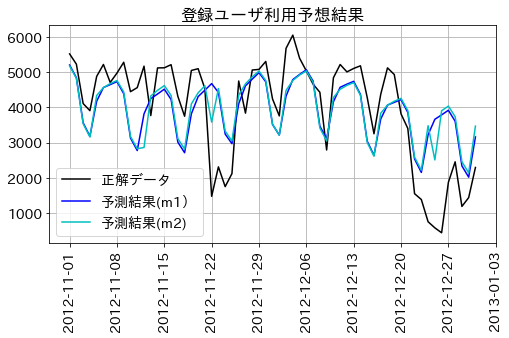

In [54]:
# 時系列グラフの描画
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8,4))

# グラフの描画
ax.plot(dates_test, ytest1, label='正解データ', c='k')
ax.plot(dates_test, ypred1, label='予測結果(m1）', c='b')
ax.plot(dates_test, ypred2, label='予測結果(m2)', c='c')

# 日付目盛間隔
# 木曜日毎に日付を表示
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

#　方眼表示など
ax.grid()
ax.legend()
ax.set_title('登録ユーザ利用予想結果')

# 画面出力
plt.show()

### チューニング Step2  

 Prophetでは、先ほど指定した特定日(holidays)の設定と別に, 回帰の場合と同様の、日付以外の項目を入力データに追加する機能を持っている

  モデルの入力項目として, 「天気」「気温」「風速」「湿度」を追加する

In [55]:
# 学習データに「天気」「気温」「風速」「湿度」を追加
df3 = pd.concat([df2, df[['天気', '気温', '風速', '湿度']]], axis=1)

# 入力データの分割
x2_train = df3[train_index]
x2_test = df3[test_index]

#　結果確認
display(x2_train.tail())

,ds,y,天気,気温,風速,湿度
665,2012-10-27,5209,2,0.5300,0.2357,0.7200
666,2012-10-28,3461,2,0.4775,0.3980,0.6946
667,2012-10-29,20,3,0.4400,0.3582,0.8800
668,2012-10-30,1009,2,0.3182,0.2130,0.8255
669,2012-10-31,5147,2,0.3575,0.1667,0.6667


In [60]:
# アルゴリズムの選択
m3 = Prophet(yearly_seasonality=True, 
             weekly_seasonality=True, daily_seasonality=False,
             seasonality_mode='multiplicative', holidays = df_add)

# add_regressor関数で、「天気」「気温」「風速」「湿度」をモデルに組み込む
m3.add_regressor('天気')
m3.add_regressor('気温')
m3.add_regressor('風速')
m3.add_regressor('湿度')

# 学習
m3.fit(x2_train)

In [63]:
# 予測用の入力データを作る
future3 = df3[['ds', '天気', '気温', '風速', '湿度']]

# 予測
fcst3 = m3.predict(future3)

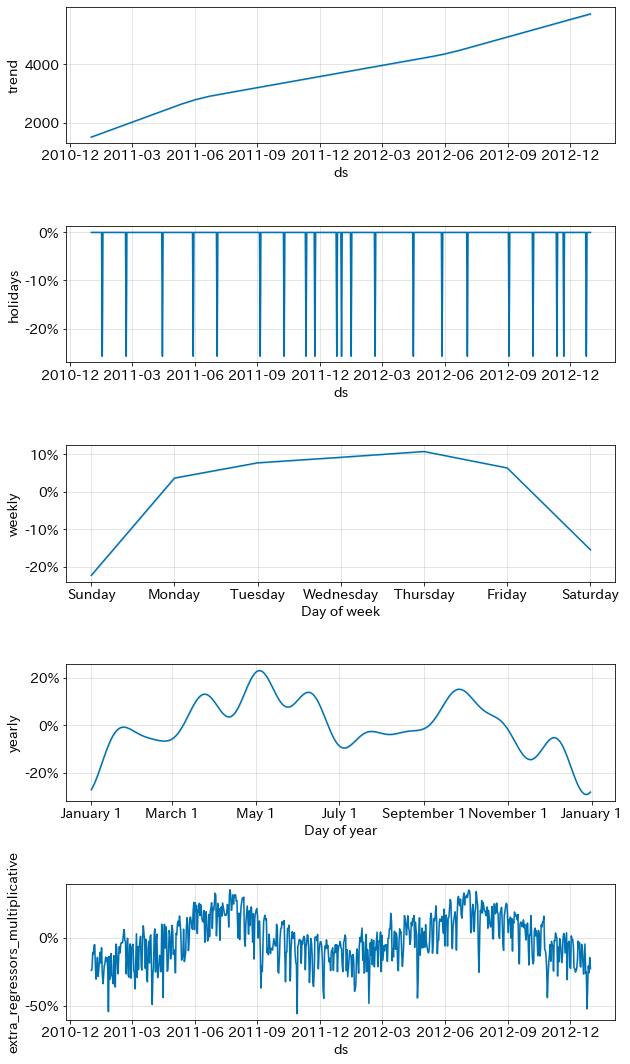

In [64]:
# 要素ごとのグラフ描画
fig = m3.plot_components(fcst3)
plt.show()

In [65]:
# R値の計算

# fcstから予測部分のみ抽出する
ypred3 = fcst3[-61:][['yhat']].values
score3 = r2_score(ytest1, ypred3)

# 結果確認
r2_text3 = f'R2 score:{score3:.4f}'
print(r2_text3)

R2 score:0.6202


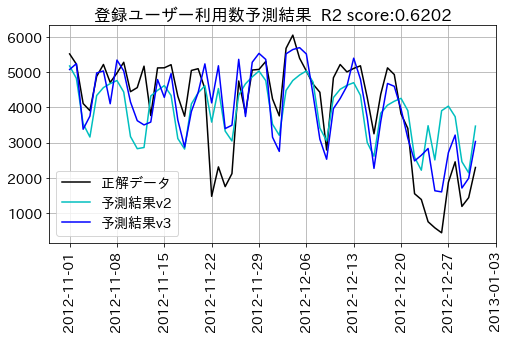

In [66]:
# 時系列グラフの描画 
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 4))

# グラフ描画
ax.plot(dates_test, ytest1, label='正解データ', c='k')
ax.plot(dates_test, ypred2, label='予測結果v2', c='c')
ax.plot(dates_test, ypred3, label='予測結果v3', c='b')

# 日付目盛間隔
# 木曜日ごとに日付を表示
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

# 方眼表示など
ax.grid()
ax.legend()
ax.set_title('登録ユーザー利用数予測結果  ' + r2_text3)

# 画面出力
plt.show()